# <center> Potato Desease Classification

### Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

## Import all the Dependencies

In [55]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import os

## Set all the Constants

In [24]:
batch = 32
image_size = 256
chanel = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle = True,
    image_size = (image_size, image_size),
    batch_size = batch
)

Found 2152 files belonging to 3 classes.


In [42]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [44]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0 0 1 0 2 0 0 0 1 1 2 0 1]


## Visualize some of the images from our dataset

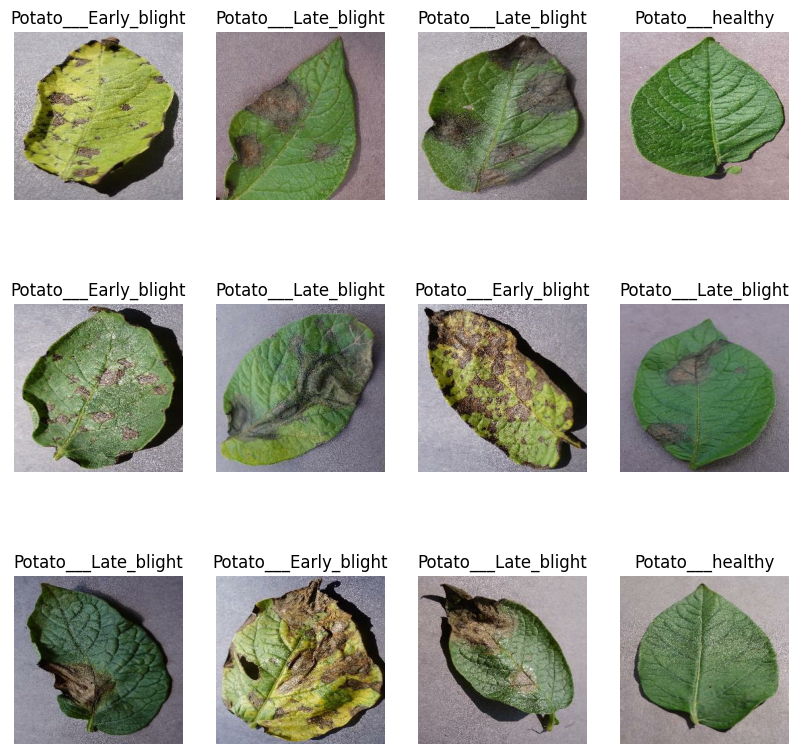

In [4]:
plt.figure(figsize=(10,10))
for image, label in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(dataset.class_names[label[i]])
        plt.axis('off')

## Function to Split Dataset

In [5]:
# train_ds = dataset.take(int(len(dataset)*0.8))
# remain_ds = dataset.skip(int(len(dataset)*0.8))
# val_ds = remain_ds.take(int(len(dataset)*0.1))
# test_ds = remain_ds.skip(int(len(dataset)*0.1))

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    """This function takes a TensorFlow dataset (ds) and splits it into training, validation, 
    and test sets based on the specified proportions. It can also shuffle the dataset before 
    splitting if shuffle is set to True. The buffer size for shuffling is controlled by the 
    shuffle_size parameter. The function returns three datasets corresponding to the training, 
    validation, and test sets."""

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_ds = dataset.take(int(len(dataset)*train_split))
    val_ds = dataset.skip(int(len(dataset)*train_split)).take(int(len(dataset)*val_split))
    test_ds = dataset.skip(int(len(dataset)*train_split)).skip(int(len(dataset)*val_split))
    
    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

## Cache, Shuffle, and Prefetch the Dataset

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.experimental.preprocessing.Rescaling(1./255)
])

### Data Augmentation

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(.5, .2)
])

In [29]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation= 'relu', input_shape=(batch,image_size,image_size, chanel)),
    layers.MaxPool2D(2,2),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax'),
])

model.build(input_shape=(batch,image_size,image_size, chanel))

In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                 

### Compiling the Model

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [32]:
history = model.fit(
    train_ds,
    batch_size=batch,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 199s 3s/step - loss: 0.8776 - accuracy: 0.5029 - val_loss: 0.6710 - val_accuracy: 0.6667
Epoch 2/50
54/54 [==============================] - 132s 2s/step - loss: 0.6027 - accuracy: 0.7263 - val_loss: 0.4735 - val_accuracy: 0.8542
Epoch 3/50
54/54 [==============================] - 140s 3s/step - loss: 0.4561 - accuracy: 0.8131 - val_loss: 0.4653 - val_accuracy: 0.8802
Epoch 4/50
54/54 [==============================] - 153s 3s/step - loss: 0.4156 - accuracy: 0.8345 - val_loss: 0.4705 - val_accuracy: 0.8229
Epoch 5/50
54/54 [==============================] - 180s 3s/step - loss: 0.3647 - accuracy: 0.8519 - val_loss: 0.4820 - val_accuracy: 0.8542
Epoch 6/50
54/54 [==============================] - 195s 4s/step - loss: 0.2741 - accuracy: 0.8958 - val_loss: 0.3439 - val_accuracy: 0.8698
Epoch 7/50
54/54 [==============================] - 178s 3s/step - loss: 0.1861 - accuracy: 0.9317 - val_loss: 0.2748 - val_accuracy: 0.8854
Epoch 8/50
54

In [33]:
score = model.evaluate(test_ds)

8/8 [==============================] - 43s 570ms/step - loss: 0.3173 - accuracy: 0.9138


In [34]:
score

[0.31732743978500366, 0.9137930870056152]

### Plotting the Accuracy and Loss Curves

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 50

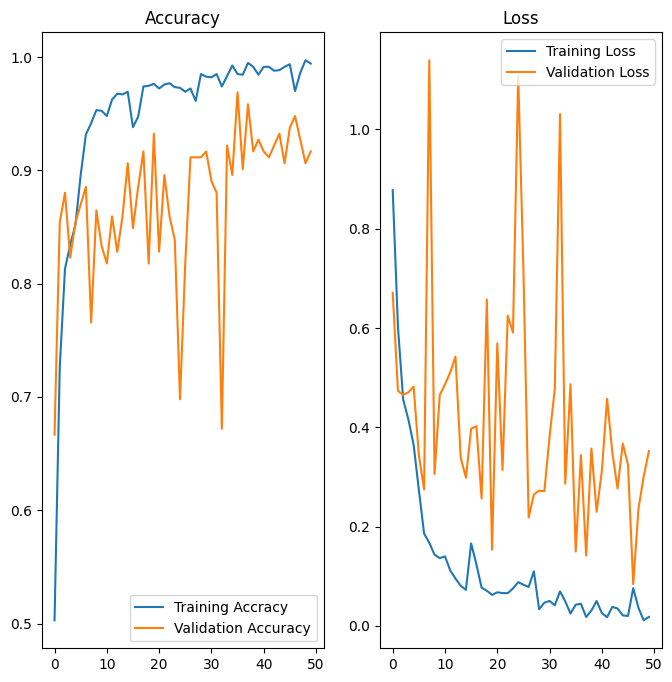

In [38]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), acc, label='Training Accracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

### Run prediction on a sample image

first image to print
Actual label: Potato___Late_blight
1/1 [==============================] - 1s 707ms/step
predicted label: Potato___Late_blight


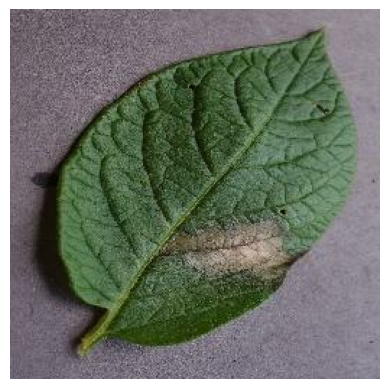

In [51]:
for image_batch, label_batch in test_ds.take(1):
    image_1 = image_batch[0].numpy().astype('uint8')
    label_1 = label_batch[0].numpy()
    
    print('first image to print')
    plt.imshow(image_1)
    print('Actual label:', class_names[label_1])
    
    prediction = model.predict(image_batch)
    print('predicted label:', class_names[np.argmax(prediction[0])])
    
    plt.axis('off')

### rite a function for inference

In [52]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step


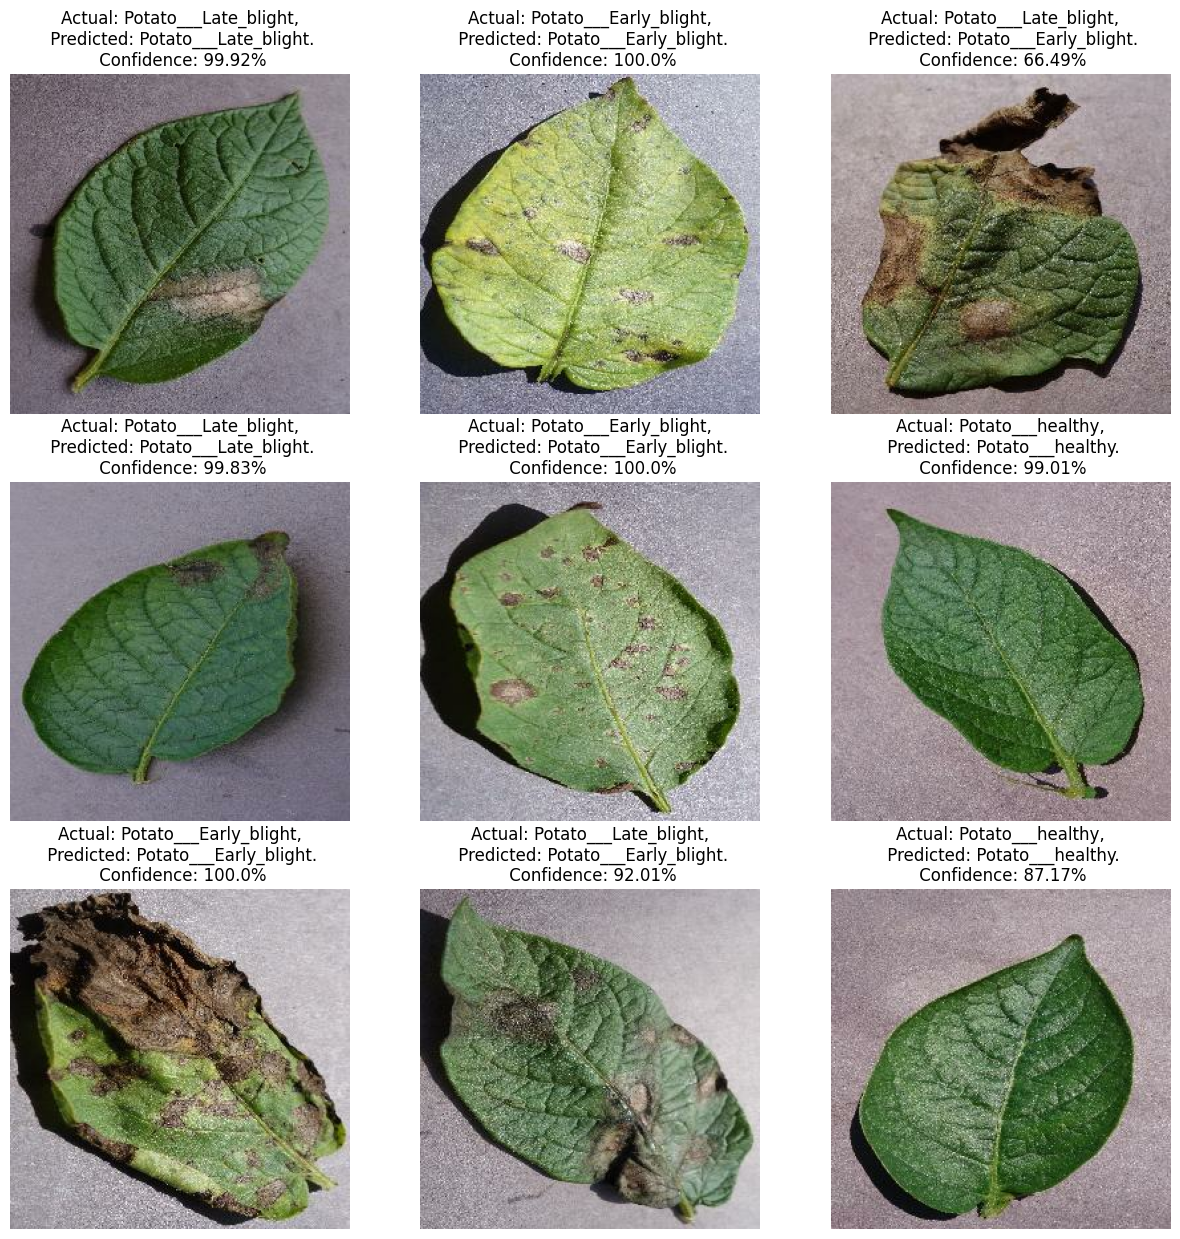

In [53]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Saving the Model

In [59]:
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

In [60]:
model.save("potatoes.h5")